<a href="https://colab.research.google.com/github/sonusingh43/Nlp_Disaster_Kaggle/blob/master/Nlp_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install bert-for-tf2 >> /dev/null

In [0]:
!pip install tqdm  >> /dev/null

In [0]:
#!pip uninstall tensorflow-gpu==2.0.0-rc0

In [0]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
#import tqdm as tqdm
import re

In [39]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [41]:
train_data.shape,test_data.shape

((7613, 5), (3263, 4))

In [42]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [43]:
train_data['target'].unique()

array([1, 0])

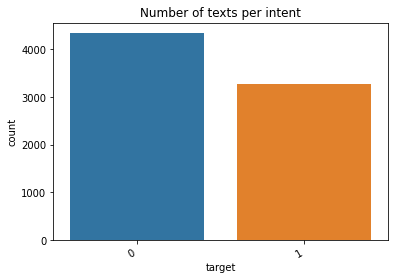

In [44]:
chart = sns.countplot(train_data.target)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [45]:
train_data['keyword'].isnull().sum()


61

In [46]:
train_data['keyword'].nunique(),test_data['keyword'].nunique()

(221, 221)

In [47]:
train_data['location'].nunique(),test_data['location'].nunique()

(3341, 1602)

In [48]:
train_data['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [49]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=train_data['keyword'].tolist(),
            #y=train_data['keyword'].nunique(),
            orientation='h'))

fig.show()

In [0]:
train_data=train_data.drop(['keyword', 'location'], axis=1)

In [51]:
train_data['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

#Clean the Text

*   Make text to lowercase
*   Remove URL
*   Remove HTML special Character
*   Remove HashTag
*   Remove Punctuations




In [0]:
def clean_text(text):
  
  # Remove Urls
  text= re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", str(text))
  
  # Remove HTML special entities (e.g. &amp;)
  text = re.sub(r'\&\w*;', '', str(text))
  
  # Remove hashtag (#)
  text = re.sub(r'#','', str(text))

  # Remove punctuation
  text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\()\']", " ", str(text)).split())
 
  #https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
  #Remove Emoji
  text=str(text).encode('ascii', 'ignore').decode('ascii')

  text=str(text).lower()
  return text



In [0]:
# Remove Urls
  #train_data['text']= re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", train_data['text'])
  
  # Remove HTML special entities (e.g. &amp;)
  #text = re.sub(r'\&\w*;', '', text)
  
  # Remove hashtag (#)
  #train_data['text'] = re.sub(r'#','', str(train_data['text']))

  # Remove punctuation
  #text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())

  #Remove Emoji
  #text.encode('ascii', 'ignore').decode('ascii')

  #text.lower()

In [54]:

train_data['text'] =train_data['text'].apply(clean_text)
train_data.head(25)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13 000 people receive wildfires evacuation ord...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update > california hwy 20 closed in...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,i m on top of the hill and i can see a fire in...,1
8,14,there s an emergency evacuation happening now ...,1
9,15,i m afraid that the tornado is coming to our area,1


In [0]:
my_stopword=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']

In [0]:
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopword)]))

In [57]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
test_data=test_data.drop(['keyword', 'location'], axis=1)

In [59]:
test_data['text'] =test_data['text'].apply(clean_text)
test_data.head()

,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills 28 in china and taiwan


In [0]:
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopword)]))

In [61]:
test_data['text'].head()

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4               typhoon soudelor kills 28 china taiwan
Name: text, dtype: object

In [0]:
#!pip uninstall tokenizers

In [0]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [65]:
!pip install sentencepiece

In [0]:
import tokenization
import sentencepiece as spm
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
def Process_Bert(texts, max_len=256):
    all_input_ids=[]
    all_mask_ids=[]
    all_seg_ids=[]
    for token in texts: 
    
        text = tokenizer.tokenize(token)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        # input_ids += padding
        # mask_ids += padding
        # seg_ids += padding
        all_input_ids.append(tokens)
        all_mask_ids.append(pad_masks)
        all_seg_ids.append(segment_ids)

    
    return np.array(all_input_ids), np.array(all_mask_ids), np.array(all_seg_ids)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
  train_data['text'],train_data['target'], test_size=0.2, random_state=42)

In [0]:
train_input=Process_Bert(X_train,max_len=32)
test_input=Process_Bert(X_test,max_len=32)

In [0]:
train_labels = train_data.target.values

In [0]:
def build_model(bert_layer, max_len=128):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="all_input_ids")
    mask_ids = Input(shape=(max_len,), dtype=tf.int32, name="all_mask_ids")
    seg_ids = Input(shape=(max_len,), dtype=tf.int32, name="all_seg_ids")

    pooled_output, sequence_output = bert_layer([input_ids,mask_ids,  seg_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids,  mask_ids,  seg_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [72]:
model = build_model(bert_layer, max_len=260)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
all_input_ids (InputLayer)      [(None, 260)]        0                                            
__________________________________________________________________________________________________
all_mask_ids (InputLayer)       [(None, 260)]        0                                            
__________________________________________________________________________________________________
all_seg_ids (InputLayer)        [(None, 260)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   all_input_ids[0][0]              
                                                                 all_mask_ids[0][0]         

In [73]:
model.fit(
    train_input, 
    y_train,
    validation_data=(test_input, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5


191/191 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.7530 WARNING:tensorflow:Model was constructed with shape (None, 260) for input Tensor("all_input_ids_1:0", shape=(None, 260), dtype=int32), but it was called on an input with incompatible shape (None, 32).


191/191 [==============================] - 2103s 11s/step - loss: 0.5180 - accuracy: 0.7530 - val_loss: 0.4349 - val_accuracy: 0.8109
Epoch 2/5
191/191 [==============================] - 2095s 11s/step - loss: 0.3888 - accuracy: 0.8338 - val_loss: 0.4154 - val_accuracy: 0.8273
Epoch 3/5
191/191 [==============================] - 2103s 11s/step - loss: 0.3347 - accuracy: 0.8589 - val_loss: 0.4152 - val_accuracy: 0.8293
Epoch 4/5
191/191 [==============================] - 2098s 11s/step - loss: 0.2811 - accuracy: 0.8874 - val_loss: 0.4335 - val_accuracy: 0.8181
Epoch 5/5
191/191 [==============================] - 2102s 11s/step - loss: 0.2261 - accuracy: 0.9122 - val_loss: 0.4628 - val_accuracy: 0.8102


In [0]:
model.save('BertDisasterModel.h5')

In [0]:
pred=test_data['text']

In [0]:
pred_input = Process_Bert(pred, max_len=32)

In [80]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [0]:
submission=pd.read_csv("sample_submission.csv")

In [82]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [83]:
predModel = model.predict(pred_input)
model.load_weights('BertDisasterModel.h5')
print("saving the model to csv file.....")
submission['target'] =predModel.round().astype(int)
submission2=submission.to_csv('nlp_submission.csv',index=False)

saving the model to csv file.....


In [0]:
predictedValue=pd.read_csv('nlp_submission.csv')

In [87]:
len(predictedValue)

3263

In [89]:
predictedValue.head(25)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
